In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

# Load the preprocessed dataset
df = pd.read_csv('final_data.csv')
print("Dataset loaded successfully. First few rows:")
print(df.head())

Dataset loaded successfully. First few rows:
   Unnamed: 0.1            timestamp  Unnamed: 0   demand  precipIntensity  \
0             0  2019-05-27 01:00:00       96549  12432.0         0.001211   
1             1  2019-05-27 02:00:00       96550  11662.0         0.001050   
2             2  2019-05-27 03:00:00       96551  11164.0         0.000969   
3             3  2019-05-27 04:00:00       96552  10768.0         0.000727   
4             4  2019-05-27 05:00:00       96553  10565.0         0.000000   

   precipProbability  temperature  humidity  pressure  windSpeed  ...  \
0               0.01     0.734088      0.58  0.566616   0.396703  ...   
1               0.01     0.711725      0.64  0.565084   0.377656  ...   
2               0.01     0.694160      0.70  0.562021   0.366667  ...   
3               0.01     0.687551      0.72  0.557427   0.400000  ...   
4               0.00     0.681666      0.74  0.555896   0.390110  ...   

   city_philadelphia  city_phoenix  city_san an

In [2]:
# Select features for clustering (weather and demand features)
# Fixed column name: 'precip' to 'precipIn'
clustering_features = ['demand', 'temperature', 'humidity', 'windSpeed', 'pressure', 'precipIntensity']
X_clustering = df[clustering_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
print("Features standardized for clustering.")

Features standardized for clustering.


In [3]:
# Dimensionality Reduction with PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("PCA applied for 2D visualization.")

PCA applied for 2D visualization.


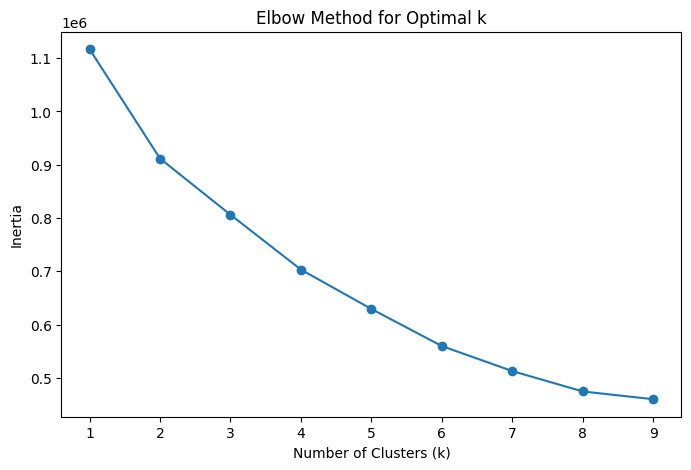

In [4]:
# Determine optimal number of clusters using the elbow method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.savefig('elbow_plot.png')
plt.show()

In [7]:
# Import MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans

# Apply MiniBatchKMeans with k=3 (assumed optimal from elbow plot; adjust if needed)
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=50000, max_iter=100)
clusters = kmeans.fit_predict(X_scaled)

# Evaluate clustering with silhouette score on a random subset (e.g., 50,000 samples)
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), size=50000, replace=False)
X_sample = X_scaled[sample_indices]
clusters_sample = clusters[sample_indices]
sil_score = silhouette_score(X_sample, clusters_sample)
print(f"Silhouette Score for k=3 (on a sample of 50,000 points): {sil_score}")

# Add cluster labels to the dataframe
df['cluster'] = clusters
print("Clustering completed using MiniBatchKMeans.")

Silhouette Score for k=3 (on a sample of 50,000 points): 0.19121710853373827
Clustering completed using MiniBatchKMeans.


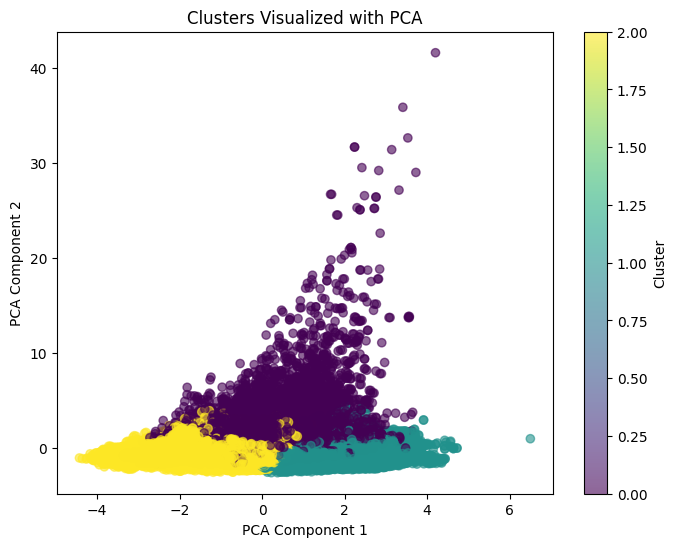

Cluster Summary (Mean Values):
               demand  temperature  humidity  windSpeed  pressure  \
cluster                                                             
0         7717.715127     0.483050  0.726714   0.386198  0.599493   
1        11136.801933     0.697444  0.539405   0.231024  0.555985   
2         5549.719069     0.475341  0.707614   0.146160  0.636548   

         precipIntensity  
cluster                   
0               0.010964  
1               0.001513  
2               0.001204  


In [8]:
# Visualize clusters using PCA
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.savefig('cluster_visualization.png')
plt.show()

# Interpret clusters by computing mean feature values for each cluster
cluster_summary = df.groupby('cluster')[clustering_features].mean()
print("Cluster Summary (Mean Values):")
print(cluster_summary)

In [12]:
# Prepare data for forecasting
# Features: weather, temporal features, city indicators; Target: demand
features = ['temperature', 'humidity', 'windSpeed', 'pressure', 'precipIntensity', 'hour',
            'day_of_week', 'month', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter',
            'city_dallas', 'city_houston', 'city_la', 'city_nyc', 'city_philadelphia',
            'city_phoenix', 'city_san antonio', 'city_san diego', 'city_san jose', 'city_seattle']
X = df[features]
y = df['demand']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("Data prepared and split for forecasting.")

Data prepared and split for forecasting.


In [13]:
# Train a Random Forest model (ensemble method using bagging)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest model trained.")

Random Forest model trained.


In [14]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Naive baseline: Use the previous day's same hour demand as prediction (shift by 24 hours)
y_naive = y_test.shift(24).fillna(method='bfill')

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mape_rf = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Evaluate the naive baseline
mae_naive = mean_absolute_error(y_test, y_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
mape_naive = np.mean(np.abs((y_test - y_naive) / y_test)) * 100

print("Random Forest Performance:")
print(f"MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, MAPE: {mape_rf:.2f}%")
print("Naive Baseline Performance:")
print(f"MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.2f}%")

Random Forest Performance:
MAE: 4420.21, RMSE: 5475.15, MAPE: 127.49%
Naive Baseline Performance:
MAE: 317.11, RMSE: 710.96, MAPE: 6.36%


C:\Users\Salman\AppData\Local\Temp\ipykernel_12360\3667152554.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_naive = y_test.shift(24).fillna(method='bfill')


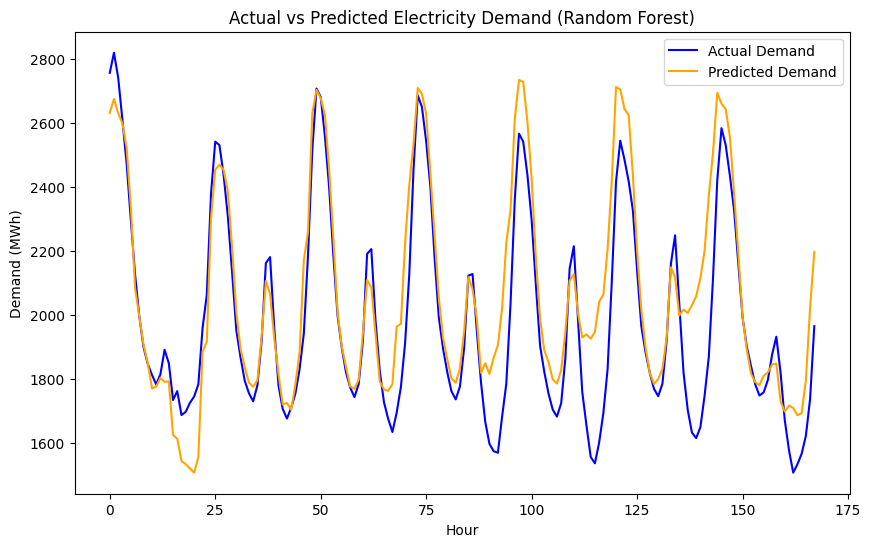

In [15]:
# Plot actual vs predicted demand (first week of test data)
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:168], label='Actual Demand', color='blue')
plt.plot(y_pred[:168], label='Predicted Demand', color='orange')
plt.title('Actual vs Predicted Electricity Demand (Random Forest)')
plt.xlabel('Hour')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.savefig('forecast_plot.png')
plt.show()

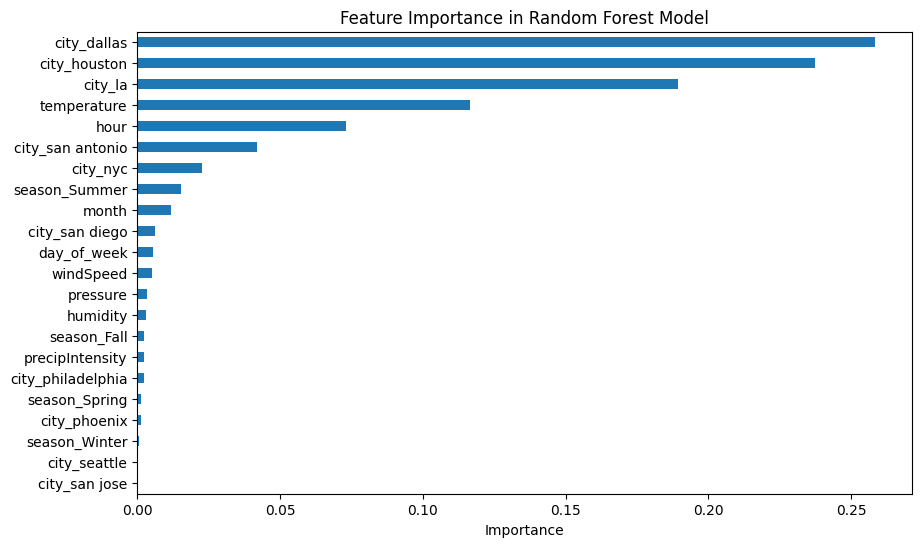

In [17]:
# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=features)
plt.figure(figsize=(10, 6))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.savefig('feature_importance.png')
plt.show()

In [18]:
# Import joblib to save models
import joblib

# Save the scaler, PCA, and K-Means model for clustering
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')
joblib.dump(kmeans, 'kmeans.joblib')

# Save the Random Forest model for forecasting
joblib.dump(rf_model, 'rf_model.joblib')

# Export PCA-transformed data with clusters for visualization
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = clusters
pca_df.to_csv('pca_clusters.csv', index=False)

# Export test set predictions for time-series plot
forecast_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred
})
forecast_df.to_csv('forecast_results.csv', index=False)

print("Models and data saved for front-end use.")

Models and data saved for front-end use.
